In [1]:
!git clone https://github.com/arminwitte/FoolsUNet.git

Cloning into 'FoolsUNet'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 93 (delta 40), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (93/93), 2.62 MiB | 6.67 MiB/s, done.


In [2]:
import tensorflow as tf
print(tf.__version__)

2024-05-19 22:43:20.915046: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-19 22:43:20.915142: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-19 22:43:21.018532: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


In [3]:
from tensorflow.keras import layers

In [4]:
class SqueezeExcite(layers.Layer):
    """
    https://keras.io/examples/vision/patch_convnet/

    Applies squeeze and excitation to input feature maps as seen in
    https://arxiv.org/abs/1709.01507.

    Args:
        ratio: The ratio with which the feature map needs to be reduced in
        the reduction phase.

    Inputs:
        Convolutional features.

    Outputs:
        Attention modified feature maps.
    """

    def __init__(self, ratio, **kwargs):
        super().__init__(**kwargs)
        self.ratio = ratio

    def get_config(self):
        config = super().get_config()
        config.update({"ratio": self.ratio})
        return config

    def build(self, input_shape):
        filters = input_shape[-1]
        self.squeeze = layers.GlobalAveragePooling2D(keepdims=True)
        self.reduction = layers.Dense(
            units=filters // self.ratio,
            activation="relu",
            use_bias=False,
        )
        self.excite = layers.Dense(units=filters, activation="sigmoid", use_bias=False)
        self.multiply = layers.Multiply()

    def call(self, x):
        shortcut = x
        x = self.squeeze(x)
        x = self.reduction(x)
        x = self.excite(x)
        x = self.multiply([shortcut, x])
        return x

In [5]:

class InverseResidualBlock(layers.Layer):
    """Implements an Inverse Residual Block like in MobileNetV2 and MobileNetV3

    https://stackoverflow.com/a/61334159

    Args:
        features: Number of features.
        expand_factor: factor by witch to expand number of layers
        strides: Stride used in last convolution.
        batch_norm: flag if Batch Normalisation should be used.

    Inputs:
        Convolutional features.

    Outputs:
        Modified feature maps.
    """

    def __init__(self, features=16, expand_factor=4, strides=1, batch_norm=True, **kwargs):
        super().__init__(**kwargs)
        self.features = features
        self.expand_factor = expand_factor
        self.strides = strides
        self.batch_norm = batch_norm

    def get_config(self):
        config = super().get_config()
        config.update({"features": self.features,
                       "expand_factor": self.expand_factor,
                       "strides": self.strides,
                       "batch_norm": self.batch_norm, })
        return config

    def build(self, input_shape):
        self.conv1 = layers.Conv2D(self.features*self.expand_factor, (1,1), strides=1)
        if self.batch_norm:
            self.bn1 = layers.BatchNormalization()
        self.activation1 = layers.Activation('relu6')
        self.dwise = layers.DepthwiseConv2D(3, padding='same', strides=self.strides)
        if self.batch_norm:
            self.bn2 = layers.BatchNormalization()
        self.activation2 = layers.Activation('relu6')
        self.squeeze_excite = SqueezeExcite(ratio=4)
        self.conv2 = layers.Conv2D(self.features, (1,1), strides=1, padding='same')
        if self.batch_norm:
            self.bn3 = layers.BatchNormalization()

    def call(self, x):
        shortcut = x
        x = self.conv1(x)
        if self.batch_norm:
            x = self.bn1(x)
        x = self.activation1(x)
        x = self.dwise(x)
        if self.batch_norm:
            x = self.bn2(x)
        x = self.activation2(x)
        x = self.squeeze_excite(x)
        x = self.conv2(x)
        if self.batch_norm:
            x = self.bn3(x)
        if (
            # stride check enforces that we don't add residuals when spatial
            # dimensions are None
            self.strides == 1 and
            # Depth matches
             x.get_shape().as_list()[3] == shortcut.get_shape().as_list()[3]
        ):
            x = tf.keras.layers.Add()([x, shortcut])

        return x

In [6]:
class Attention(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        filters = input_shape[1][-1]
        self.conv_g = layers.Conv2D(filters, 1, padding="same")
        self.bn_g = layers.BatchNormalization()

        self.conv_s = layers.Conv2D(filters, 1, padding="same")
        self.bn_s = layers.BatchNormalization()

        self.add = layers.Add()
        self.act_1 = layers.Activation("relu")
        self.conf_out = layers.Conv2D(1, 1, padding="same")
        self.act_2 = layers.Activation("sigmoid")
        self.mul = layers.Multiply()

    def call(self, x):
        g = x[0]
        s = x[1]

        g = self.conv_g(g)
        g = self.bn_g(g)

        s = self.conv_s(s)
        s = self.bn_s(s)

        out = self.add([g,s])
        out = self.act_1(out)
        out = self.conf_out(out)
        out = self.act_2(out)
        out = self.mul([out,x[1]])
        return out

    def get_config(self):
        config = super().get_config()
        return config

In [7]:

def mlp(x, hidden_units=[2048, 1024], dropout_rate=0.1):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class MLP(layers.Layer):
    def __init__(self,hidden_units=[128,64],dropout_rate=0.1,**kwargs):
        super().__init__(**kwargs)
        self.hidden_units = []
        for units in hidden_units:
            self.hidden_units.append(layers.Dense(units, activation=tf.keras.activations.gelu))
        self.dropout = layers.Dropout(dropout_rate)
    def get_config(self):
        config = super().get_config()
        return config


    def call(self,x):
        for units in self.hidden_units:
            x = units(x)
        x = self.dropout(x)
        return x


class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.experimental.numpy.expand_dims(
            tf.experimental.numpy.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

class PatchAndEncode(layers.Layer):
    """https://blog.gopenai.com/understanding-vision-transformers-vit-with-tensorflow-and-keras-a-cifar-100-experiment-b820e08473f8"""
    def __init__(self, num_patches=64, patch_size=4, projection_dim=64):
        super().__init__()
        self.num_patches = num_patches
        self.patch_size = patch_size
        self.projection_dim = projection_dim

    def build(self, input_shape):
        # patching the input image into patches
        self.patching = layers.Conv2D(self.projection_dim, kernel_size=self.patch_size, strides=self.patch_size)
        self.reshape = layers.Reshape((self.num_patches, self.projection_dim), name='pacthes')

        # Learnable positional embeddings
        self.lambda0 = layers.Lambda(lambda x: tf.expand_dims(tf.range(self.num_patches), axis=0))
        self.embedding = layers.Embedding(input_dim=self.num_patches, output_dim=self.projection_dim)

        # Add positional embeddings to patches
        self.add = layers.Add()


    def call(self, x):
        # patching the input image into patches
        patching = self.patching(x)
        patches = self.reshape(patching)

        # Learnable positional embeddings
        lmbd = self.lambda0(patches)
        position_embeddings = self.embedding(lmbd)

        # Add positional embeddings to patches
        patches = self.add([patches,position_embeddings])
        return patches


    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [8]:
class MakeShape(layers.Layer):
    def __init__(self, shape, **kwargs):
        super().__init__(**kwargs)
        self.shape = shape
    def build(self, input_shape):
        s = self.shape
        self.dense = layers.Dense(s[1]*s[2]*s[3]//input_shape[1])
        self.reshape = layers.Reshape(s[1:])

    def call(self, x):
        x = self.dense(x)
        x = self.reshape(x)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [9]:
class TransformerBlock(layers.Layer):
    def __init__(self, num_heads=4, projection_dim=64, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.projection_dim = projection_dim

    def get_config(self):
        config = super().get_config()
        config.update({"num_heads"})

    def build(self, input_shape):
        # Layer normalization 1.
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        # Create a multi-head attention layer.
        self.attention = layers.MultiHeadAttention(
            num_heads=self.num_heads, key_dim=self.projection_dim, dropout=0.1
        )
        # Skip connection 1.
        self.add1 = layers.Add()
        # Layer normalization 2.
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        # MLP.
        self.mlp = MLP(hidden_units=[self.projection_dim*2,self.projection_dim])
        # Skip connection 2.
        self.add2 = layers.Add()

    def call(self, x):
        # Layer normalization 1.
        x1 = self.norm1(x)
        # Create a multi-head attention layer.
        attention_output = self.attention(x1, x1)
        # Skip connection 1.
        x2 = self.add1([attention_output, x])
        # Layer normalization 2.
        x3 = self.norm2(x2)
        # MLP.
        x3 = self.mlp(x3)
        # Skip connection 2.
        encoded_patches = self.add2([x3, x2])
        return encoded_patches

## U-Net

In [10]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(3, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         )  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [11]:
model = Generator()
model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │      3,072 │ input_layer[0][0] │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 64,    │    131,584 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    525,312 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 16, 16,    │  2,099,200 │ sequential_2[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 8, 8, 512) │  4,196,352 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 4, 4, 512) │  4,196,352 │ sequential_4[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 2, 2, 512) │  4,196,352 │ sequential_5[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 1, 1, 512) │  4,196,352 │ sequential_6[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 2, 2, 512) │  4,196,352 │ sequential_7[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2, 2,      │          0 │ sequential_8[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 4, 4, 512) │  8,390,656 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4, 4,      │          0 │ sequential_9[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 8, 8, 512) │  8,390,656 │ concatenate_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 8, 8,      │          0 │ sequential_10[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 16, 16,    │  8,390,656 │ concatenate_2[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 16, 16,    │          0 │ sequential_11[0]

 Total params: 54,425,859 (207.62 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 10,880 (42.50 KB)

## New model

In [12]:
def downsample1(filters, size, apply_batchnorm=True):

  result = tf.keras.Sequential([InverseResidualBlock(filters*2//3),
InverseResidualBlock(filters*2//3),
InverseResidualBlock(filters, strides =2)])
  return result


def upsample1(filters, size, apply_dropout=False):


  result = tf.keras.Sequential([
InverseResidualBlock(filters*3//2),
InverseResidualBlock(filters*3//2),
#layers.UpSampling2D(size=2),
layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    use_bias=False),
layers.BatchNormalization(),
layers.ReLU(),
])

  return result

def foolsunet(num_transformers=0):
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])
  #initializer = tf.random_normal_initializer(0., 0.02)
  #first = tf.keras.layers.Conv2D(64, 3,
  #                                      strides=1,
  #                                      padding='same',
  #                                      kernel_initializer=initializer,
  #                                      activation='relu6')  # (batch_size, 256, 256, 3)


  down_stack = [
    #InverseResidualBlock(24, strides=2),
downsample(64, 3, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    #InverseResidualBlock(32, strides=2),
downsample(128, 3),  # (batch_size, 64, 64, 128)
    downsample1(64, 3),  # (batch_size, 32, 32, 256)
    downsample1(96, 3),  # (batch_size, 16, 16, 512)
    downsample1(128, 3),  # (batch_size, 8, 8, 512)
    #downsample1(128, 4),  # (batch_size, 4, 4, 512)
    #downsample1(192, 4),  # (batch_size, 2, 2, 512)
    #downsample1(512, 4),  # (batch_size, 1, 1, 512)
  ]

  transformers = []
  if num_transformers > 0:
    transformers.append(PatchAndEncode(num_patches=64, patch_size=4, projection_dim=128))

  for _ in range(num_transformers):
    transformers.append(TransformerBlock(num_heads=12, projection_dim=128))

  if num_transformers > 0:
    transformers.append(MakeShape([None,32,32,48]))

  up_stack = [
    #upsample1(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    #upsample1(128, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    #upsample1(96, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample1(96, 3),  # (batch_size, 16, 16, 1024)
    upsample1(64, 3),  # (batch_size, 32, 32, 512)
    upsample(128, 3),  # (batch_size, 64, 64, 256)
    upsample(64, 3),  # (batch_size, 128, 128, 128)
  ]

  attention_stack = [Attention() for _ in range(len(down_stack)-1)]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(3, 3,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer)  # (batch_size, 256, 256, 3)

  x = inputs
  #x = first(x)

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # bottleneck
  for t in transformers:
    x = t(x)

  # Upsampling and establishing the skip connections
  for up, skip, attention in zip(up_stack, skips, attention_stack):
    x = up(x)
    skip = attention([x, skip])
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [13]:
model = foolsunet(0)
model.summary()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_15       │ (None, 128, 128,  │      1,728 │ input_layer_16[0… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_16       │ (None, 64, 64,    │     74,240 │ sequential_15[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_17       │ (None, 32, 32,    │    142,788 │ sequential_16[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_18       │ (None, 16, 16,    │    284,384 │ sequential_17[0]… │
│ (Sequential)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_19       │ (None, 8, 8, 128) │    499,206 │ sequential_18[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_20       │ (None, 16, 16,    │    802,464 │ sequential_19[0]… │
│ (Sequential)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 16, 16,    │     19,489 │ sequential_20[0]… │
│ (Attention)         │ 96)               │            │ sequential_18[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 16, 16,    │          0 │ sequential_20[0]… │
│ (Concatenate)       │ 192)              │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_21       │ (None, 32, 32,    │    402,880 │ concatenate_7[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 32, 32,    │      8,897 │ sequential_21[0]… │
│ (Attention)         │ 64)               │            │ sequential_17[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 32, 32,    │          0 │ sequential_21[0]… │
│ (Concatenate)       │ 128)              │            │ attention_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_22       │ (None, 64, 64,    │    147,968 │ concatenate_8[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_2         │ (None, 64, 64,    │     34,177 │ sequential_22[0]… │
│ (Attention)         │ 128)              │            │ sequential_16[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 64, 64,    │          0 │ sequential_22[0]… │
│ (Concatenate)       │ 256)              │            │ attention_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_23       │ (None, 128, 128,  │    147,712 │ concatenate_9[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_3         │ (None, 128, 128,  │      8,897 │ sequential_23[0]

 Total params: 2,578,289 (9.84 MB)

 Trainable params: 2,555,221 (9.75 MB)

 Non-trainable params: 23,068 (90.11 KB)

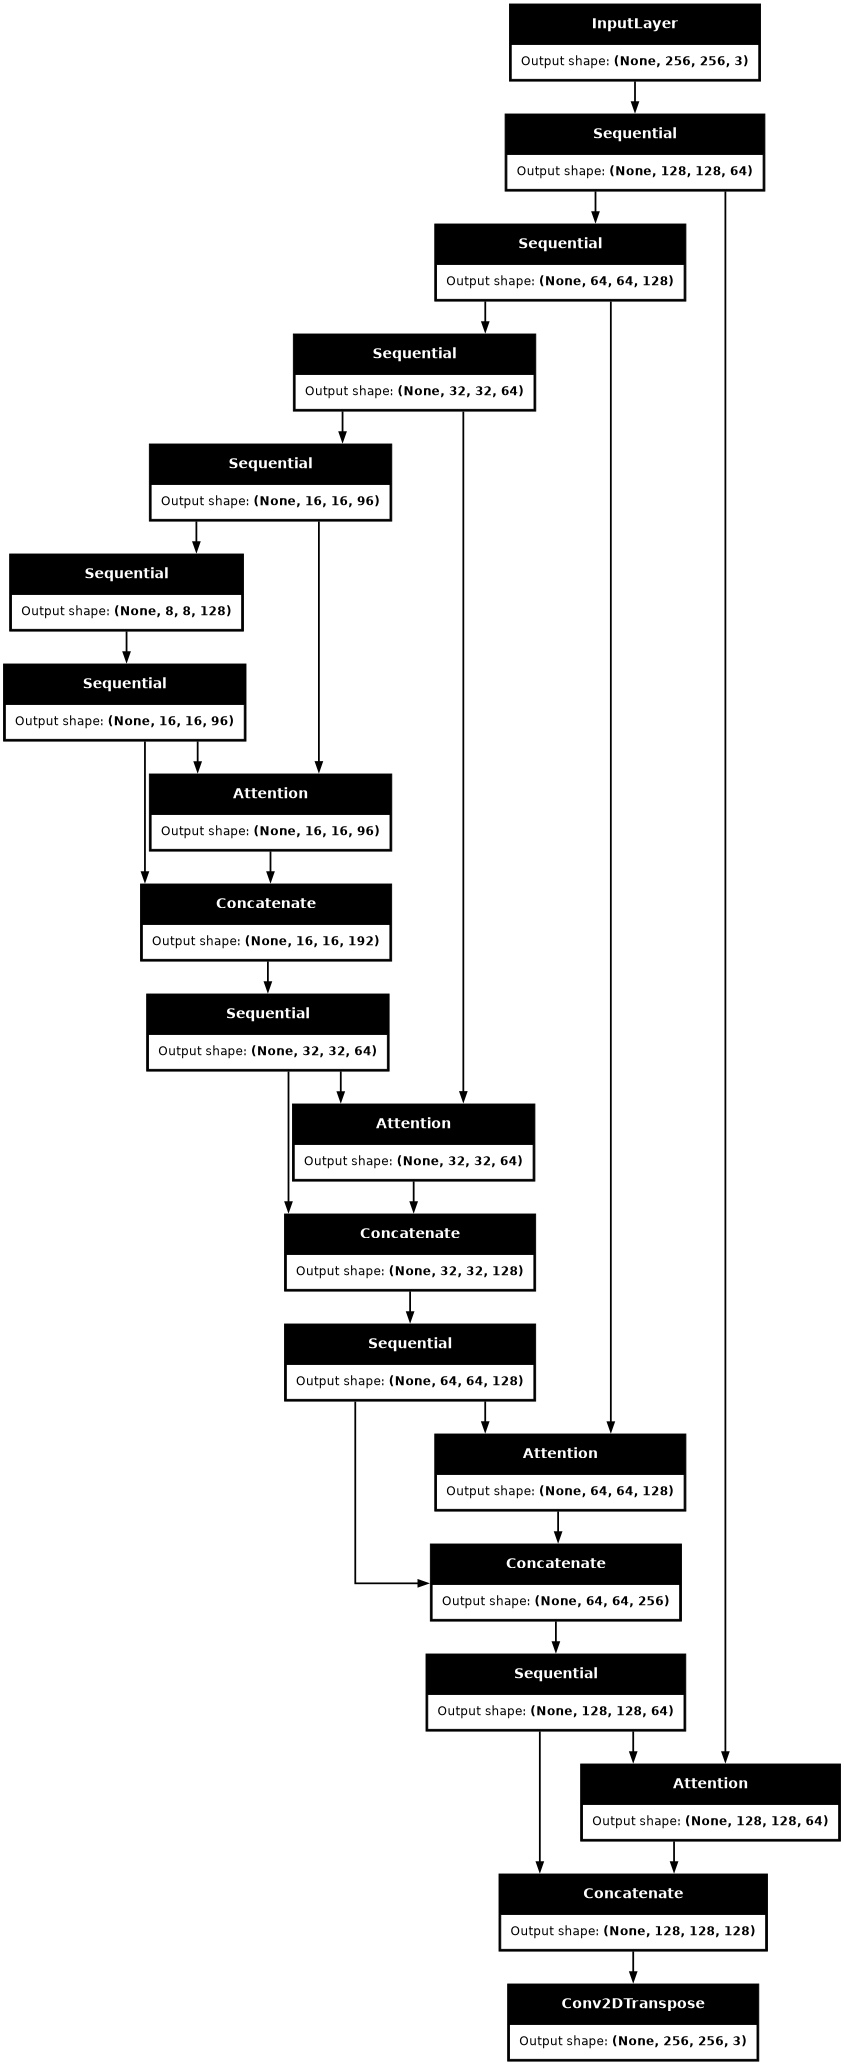

In [14]:

tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [15]:
import tensorflow_datasets as tfds

In [16]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteVXSN4Q/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteVXSN4Q/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [17]:

def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [18]:

def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (256, 256))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (256, 256),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [19]:

TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [20]:

train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [21]:

class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [22]:

train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [23]:
model = foolsunet(0)
#model = Generator()

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:

EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          #callbacks=[DisplayCallback()]
)

Epoch 1/20


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
2024-05-19 22:45:43.654169: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{k11=2} for conv (f32[64,64,129,129]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,256,64,64]{3,2,1,0}, f32[256,64,3,3]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-19 22:45:43.957699: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.303633644s
Trying algorithm eng4{k11=2} for conv (f32[64,64,129,129]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,256,64,64]{3,2,1,0}, f32[256,64,3,3]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"conv_result_scale":1,"activation_mo

57/57 ━━━━━━━━━━━━━━━━━━━━ 180s 753ms/step - accuracy: 0.6377 - loss: 0.8388 - val_accuracy: 0.5732 - val_loss: 0.9732
Epoch 2/20


W0000 00:00:1716158925.801103      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716158925.802568      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


57/57 ━━━━━━━━━━━━━━━━━━━━ 95s 586ms/step - accuracy: 0.7774 - loss: 0.5518 - val_accuracy: 0.5738 - val_loss: 0.9272
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 33s 575ms/step - accuracy: 0.8210 - loss: 0.4573 - val_accuracy: 0.5787 - val_loss: 0.9463
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 32s 562ms/step - accuracy: 0.8427 - loss: 0.4041 - val_accuracy: 0.6126 - val_loss: 0.9948
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 33s 575ms/step - accuracy: 0.8487 - loss: 0.3854 - val_accuracy: 0.5922 - val_loss: 1.0222
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 43s 760ms/step - accuracy: 0.8629 - loss: 0.3511 - val_accuracy: 0.6574 - val_loss: 1.0638
Epoch 7/20


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


57/57 ━━━━━━━━━━━━━━━━━━━━ 33s 572ms/step - accuracy: 0.8697 - loss: 0.3344 - val_accuracy: 0.6079 - val_loss: 1.0593
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 32s 569ms/step - accuracy: 0.8749 - loss: 0.3211 - val_accuracy: 0.5738 - val_loss: 1.6019
Epoch 9/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 32s 566ms/step - accuracy: 0.8819 - loss: 0.3033 - val_accuracy: 0.5961 - val_loss: 1.3126
Epoch 10/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 32s 568ms/step - accuracy: 0.8856 - loss: 0.2950 - val_accuracy: 0.7520 - val_loss: 0.6715
Epoch 11/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 32s 569ms/step - accuracy: 0.8886 - loss: 0.2843 - val_accuracy: 0.7783 - val_loss: 0.5942
Epoch 12/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 546ms/step - accuracy: 0.8914 - loss: 0.2776 - val_accuracy: 0.8766 - val_loss: 0.3305
Epoch 13/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 33s 576ms/step - accuracy: 0.8980 - loss: 0.2597 - val_accuracy: 0.8748 - val_loss: 0.3345
Epoch 14/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 33s 572ms/step - accuracy: 0.8989 - loss: 0.2552 - val_accuracy: 